In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


granularity = 'daily'
start_t = '20150701'
end_t = '20190527'
article = 'Kawhi_Leonard'
url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/'
param_str = f'{article}/{granularity}/{start_t}/{end_t}'

url = url + param_str
response = requests.get(url)
df = pd.DataFrame(response.json()['items'])
df = df.rename(columns={'timestamp': 'date', 'views': f'page views'})


In [2]:
df.head()

,access,agent,article,granularity,project,date,page views
0,all-access,user,Kawhi_Leonard,daily,en.wikipedia,2015070100,6552
1,all-access,user,Kawhi_Leonard,daily,en.wikipedia,2015070200,3395
2,all-access,user,Kawhi_Leonard,daily,en.wikipedia,2015070300,2444
3,all-access,user,Kawhi_Leonard,daily,en.wikipedia,2015070400,4036
4,all-access,user,Kawhi_Leonard,daily,en.wikipedia,2015070500,3504


In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H').dt.date
df = df[['page views', 'date']]
df = df.set_index('date')

df.head()

,page views
date,
2015-07-01,6552
2015-07-02,3395
2015-07-03,2444
2015-07-04,4036
2015-07-05,3504


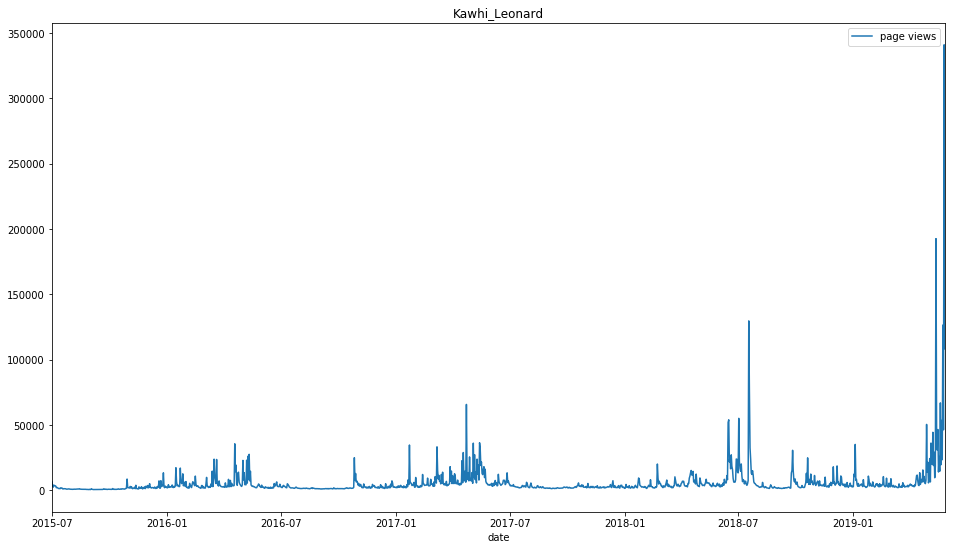

In [4]:
df.plot(figsize=(16,9))
plt.title(article)
plt.show()

In [5]:
df = df.reindex(pd.date_range(start='2015-07-01', end='2020-05-24'))
df.head()

,page views
2015-07-01,6552.0
2015-07-02,3395.0
2015-07-03,2444.0
2015-07-04,4036.0
2015-07-05,3504.0


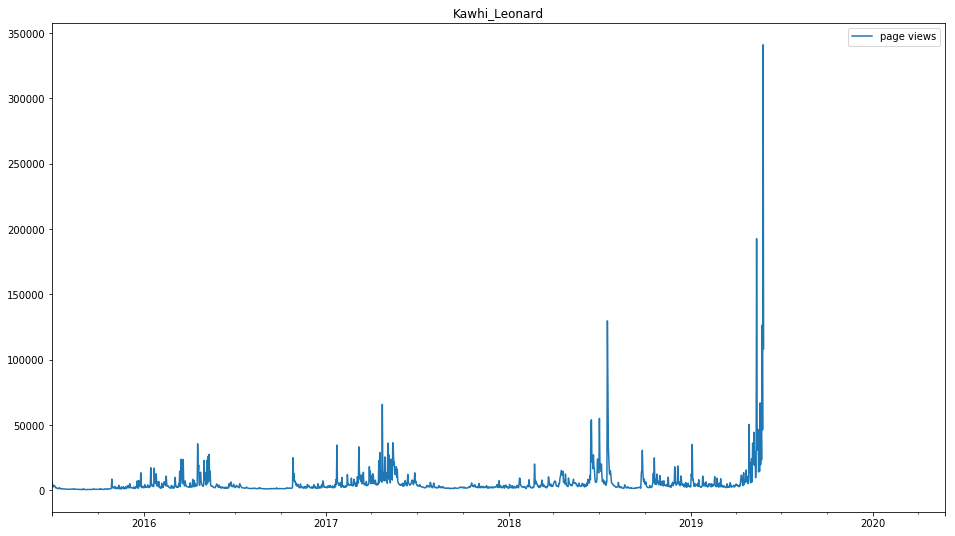

In [6]:
df.plot(figsize=(16,9))
plt.title(article)
plt.show()

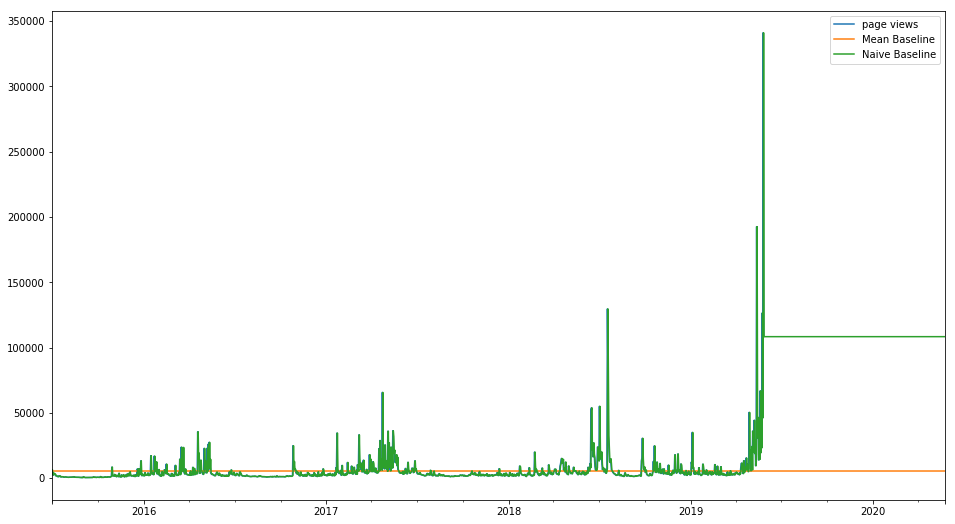

In [7]:
df['Mean Baseline'] = df['page views'].mean()
df['Naive Baseline'] = df['page views'].shift(1).ffill().bfill()
df.plot(figsize=(16,9));


In [8]:
df = df.dropna()

In [9]:
df = df['page views'].astype('float')
df = df.reset_index().rename(columns={'index': 'ds', 'page views': 'y'})

In [10]:
from fbprophet import Prophet
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
future.tail()
df.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y
0,2015-07-01,6552.0
1,2015-07-02,3395.0
2,2015-07-03,2444.0
3,2015-07-04,4036.0
4,2015-07-05,3504.0


In [11]:
forecast = m.predict(future)


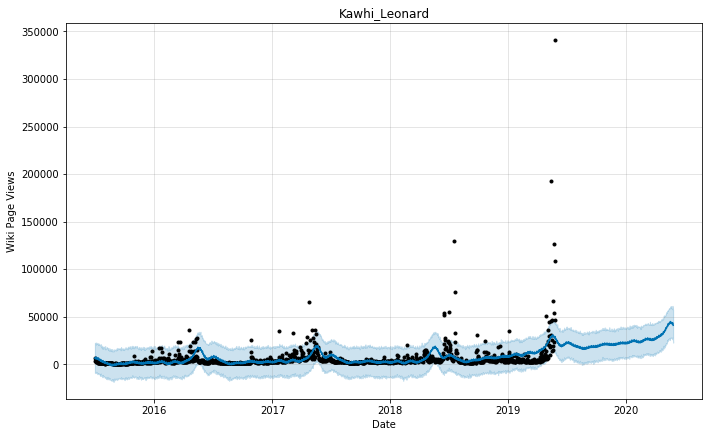

In [12]:

import matplotlib.pyplot as plt

m.plot(forecast)
plt.title(article)
plt.xlabel('Date')
plt.ylabel('Wiki Page Views')
plt.show()


In [13]:
import datetime

def prophet_predict_page_views(article, years_ahead=1):
    start_t = '20150701'
    end_t = datetime.datetime.now().strftime('%Y%m%d')
    url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/'
    param_str = f'{article}/{granularity}/{start_t}/{end_t}'
    
    url = url + param_str
    response = requests.get(url)
    df = pd.DataFrame(response.json()['items'])
    df = df.rename(columns={'timestamp': 'ds', 'views': 'y'})
    df['ds'] = pd.to_datetime(df['ds'], format='%Y%m%d%H').dt.date

    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=365*years_ahead)
    forecast = m.predict(future)
    m.plot(forecast)
    plt.title(article)
    plt.xlabel('Date')
    plt.ylabel('Wiki Page Views')
    plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


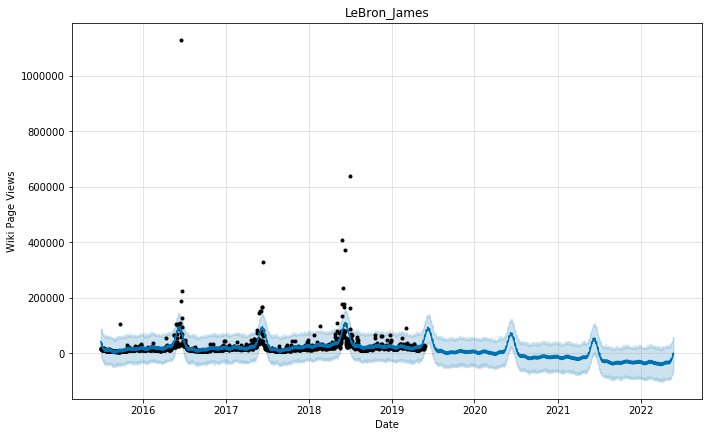

In [14]:
prophet_predict_page_views('LeBron_James', 3)